In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics, tree
from shap import plots, Explanation
import fasttreeshap
import time
import shap
from tqdm import tqdm
from matplotlib import ticker
import pickle
import lightgbm as lgb
from utils import *
import graphviz
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap

pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [3]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [4]:
ds['traffic_category'] = np.where(ds['traffic_category'] == 'Background', 'Benign', ds['traffic_category'])

In [5]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 16, 
    'n_estimators': 5, # 48
    'max_depth': 6, 
    'n_jobs': -1, 
    'verbosity': 0,
    'num_class': 5
}

bst = lgb.LGBMClassifier(**params)

rus = RandomUnderSampler(random_state=42, sampling_strategy='all')
X_res, y_res = rus.fit_resample(ds[x_features], ds['traffic_category'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12,  stratify=y_res)

![Alt text](lgb_data/learning_curve.png)

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [8]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    bst.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = bst.predict(X_res.iloc[train_index])
    y_predicted_test = bst.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='macro')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='macro')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train F1: 0.9666
Test F1: 0.9619
Fold 1:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train F1: 0.9659
Test F1: 0.9660
Fold 2:
Train F1: 0.9661
Test F1: 0.9635
Fold 3:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train F1: 0.9650
Test F1: 0.9678
Fold 4:
Train F1: 0.9655
Test F1: 0.9659
Average Train F1: 0.9658
Average Test F1: 0.9650


In [9]:
%timeit bst.fit(X_train, y_train)

The slowest run took 4.83 times longer than the fastest. This could mean that an intermediate result is being cached.
236 ms ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%time y_predicted_train = bst.predict(X_train)
%timeit y_predicted_test = bst.predict(X_test)

CPU times: user 248 ms, sys: 0 ns, total: 248 ms
Wall time: 35 ms
6.91 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
# Function to create dataframe with metrics
def performanceMetricsDF(
    metricsObj, yTrain, yPredTrain, yTest, yPredTest, average="binary"
):
    measures_list = ["ACCURACY", "PRECISION", "RECALL", "F1 SCORE"]
    train_results = [
        metricsObj.accuracy_score(yTrain, yPredTrain),
        metricsObj.precision_score(yTrain, yPredTrain, average=average),
        metricsObj.recall_score(yTrain, yPredTrain, average=average),
        metricsObj.f1_score(yTrain, yPredTrain, average=average),
    ]
    test_results = [
        metricsObj.accuracy_score(yTest, yPredTest),
        metricsObj.precision_score(yTest, yPredTest, average=average),
        metricsObj.recall_score(yTest, yPredTest, average=average),
        metricsObj.f1_score(yTest, yPredTest, average=average),

    ]
    resultsDF = pd.DataFrame(
        {"Measure": measures_list, "Train": train_results, "Test": test_results}
    )
    return resultsDF

In [60]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'macro')

,Measure,Train,Test
0,ACCURACY,0.966825,0.963946
1,PRECISION,0.968230,0.965621
2,RECALL,0.966828,0.963933
3,F1 SCORE,0.965990,0.962845


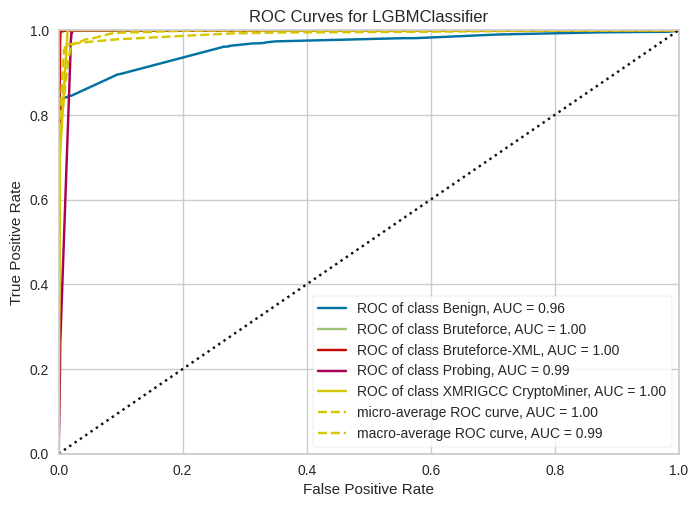

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [61]:


model = wrap(bst)
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

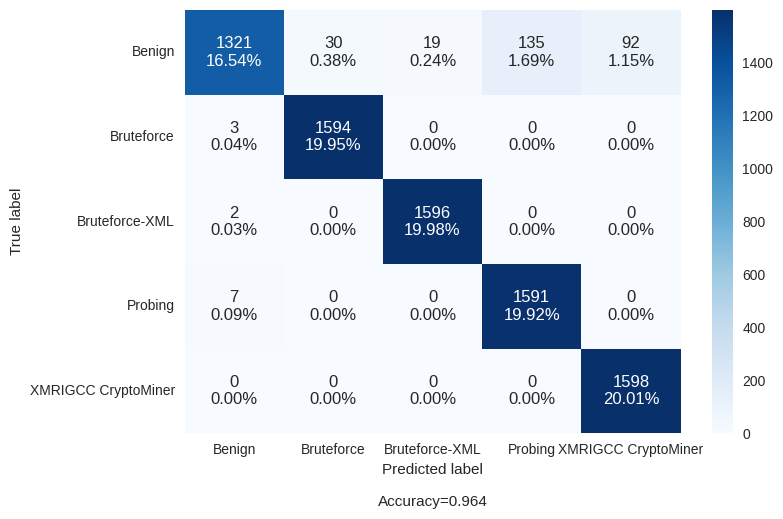

In [62]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(bst.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [63]:
# Create a plot for each tree in the model
for i in range(bst.n_estimators_):
    graph = lgb.create_tree_digraph(bst, tree_index=i, name='Tree {}'.format(i), show_info=['split_gain', 'internal_value', 'leaf_count'])
    graph.render(filename='tree_{}'.format(i), directory='lgb_data/tree', format='pdf')

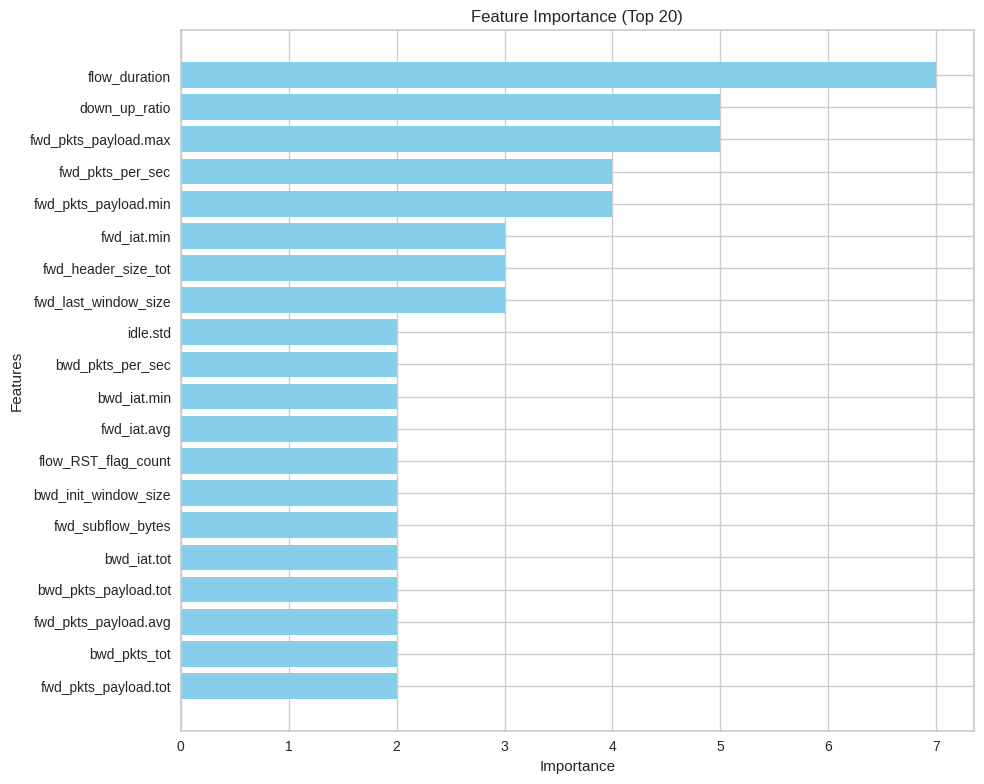

In [64]:
feature_importance = bst.feature_importances_
x_features_np = np.array(x_features)

# Sort indices based on feature importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = x_features_np[sorted_indices][:20][::-1]  # Select only the first 20 features
sorted_importance = feature_importance[sorted_indices][:20][::-1]  # Select importance values for the first 20 features

# Plotting
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.barh(range(len(sorted_importance)), sorted_importance, color='skyblue')
plt.yticks(range(len(sorted_importance)), sorted_features)  # Use yticks for feature names
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance (Top 20)')
plt.tight_layout()

# Show plot
plt.show()

In [65]:
%%time

if True:
    explainer = fasttreeshap.TreeExplainer(bst, X_train, algorithm='auto', n_jobs=-1, feature_perturbation="interventional")
    sv = explainer(X_train, check_additivity=False)

    with open('lgb_data/exp.pickle', 'wb') as handle:
        pickle.dump(sv, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("loading exp")
    with open('lgb_data/exp.pickle', 'rb') as handle:
        sv = pickle.load(handle)

 95%|=================== | 152083/159760 [00:11<00:00]       

CPU times: user 10.8 s, sys: 190 ms, total: 11 s
Wall time: 10.9 s


## Benign shap

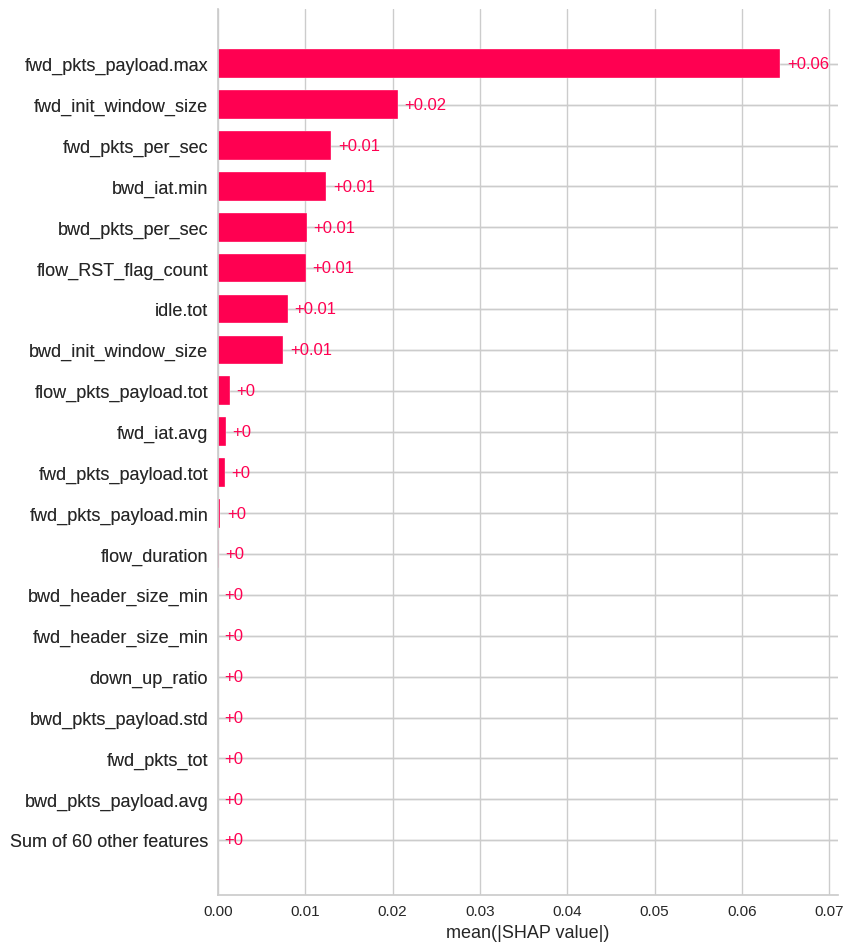

In [66]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

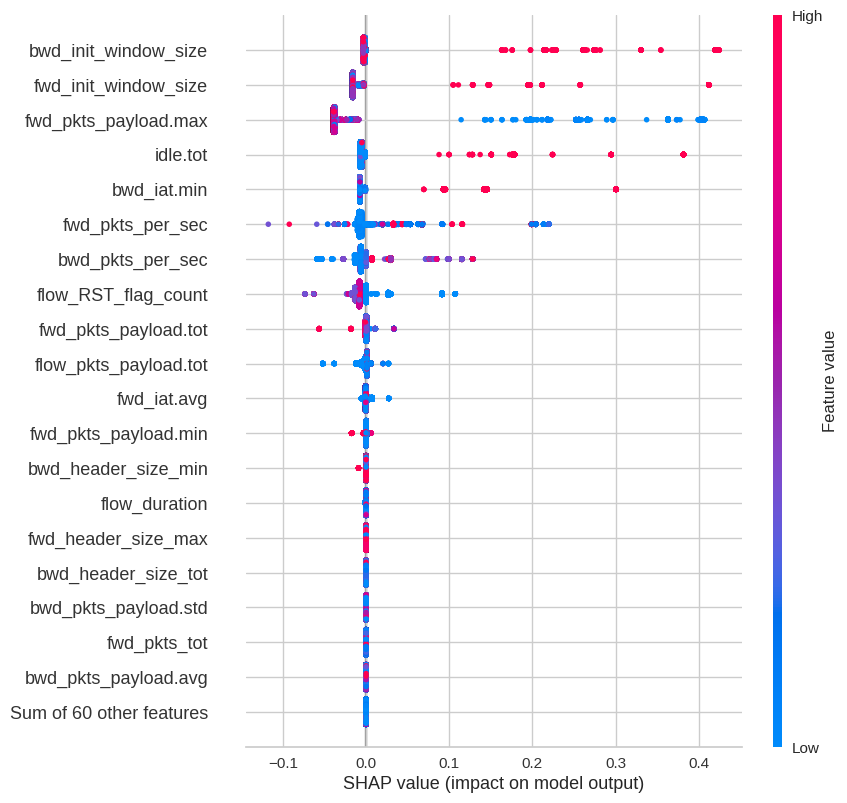

In [67]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

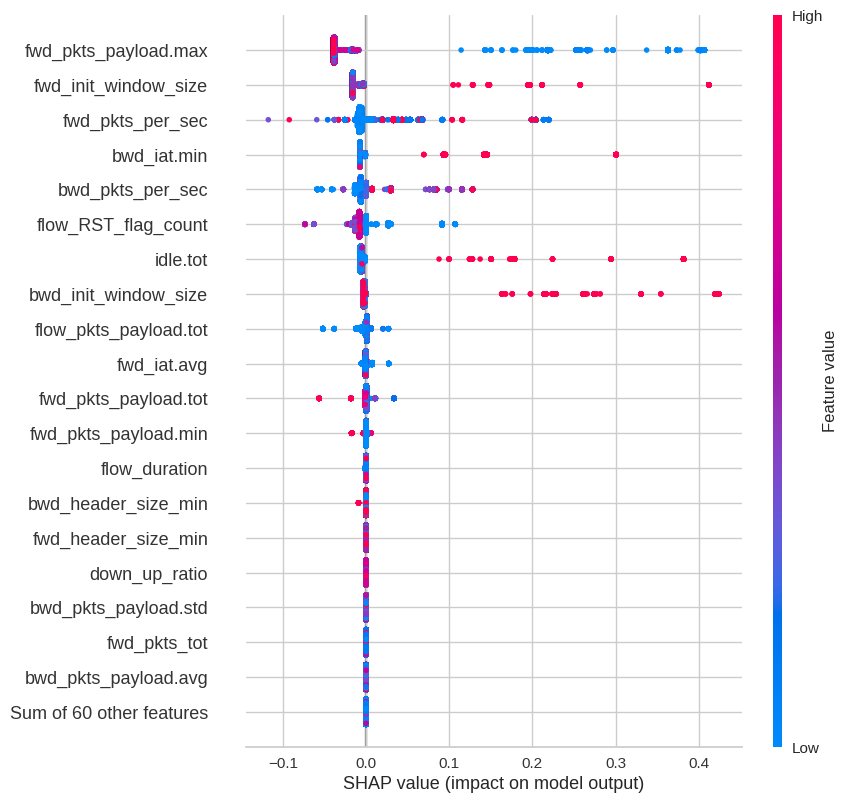

In [68]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce shap

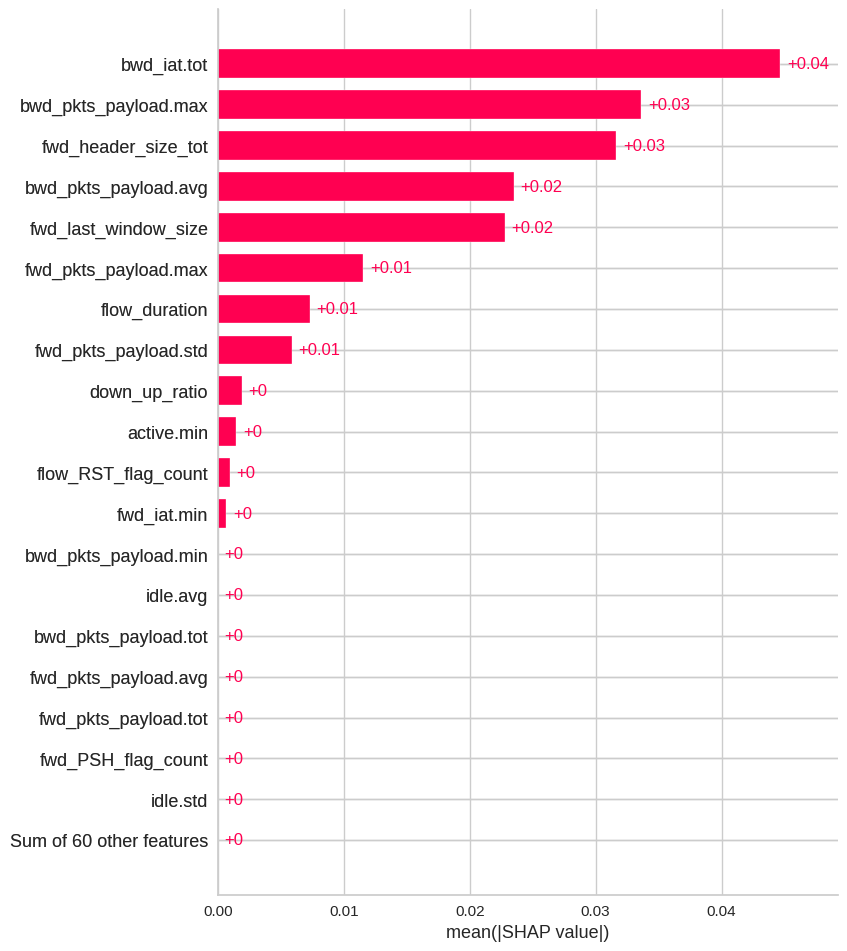

In [69]:
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

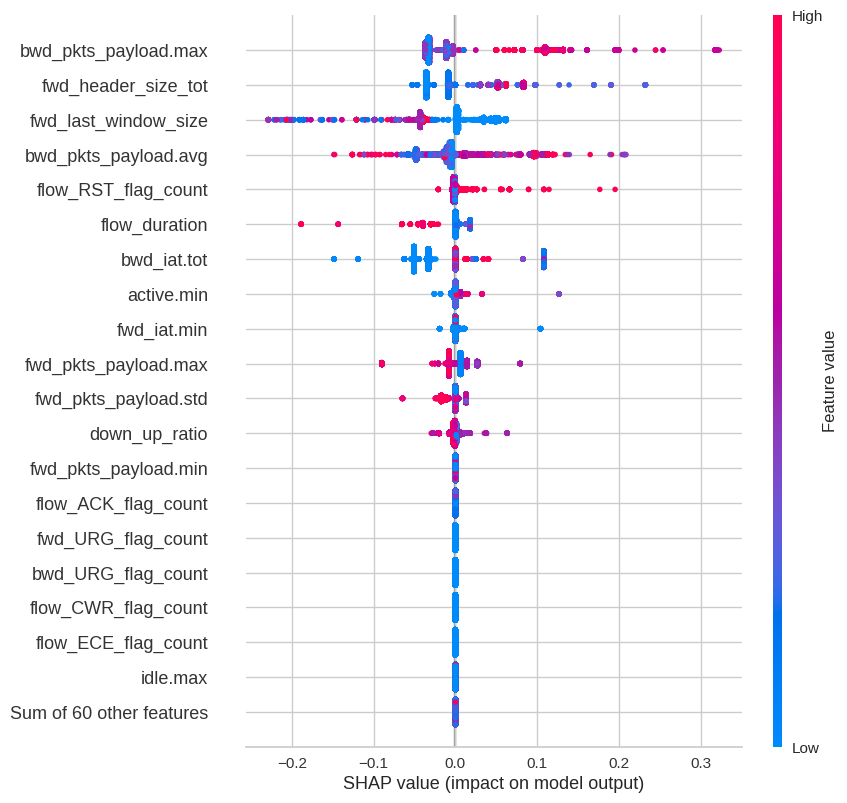

In [70]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

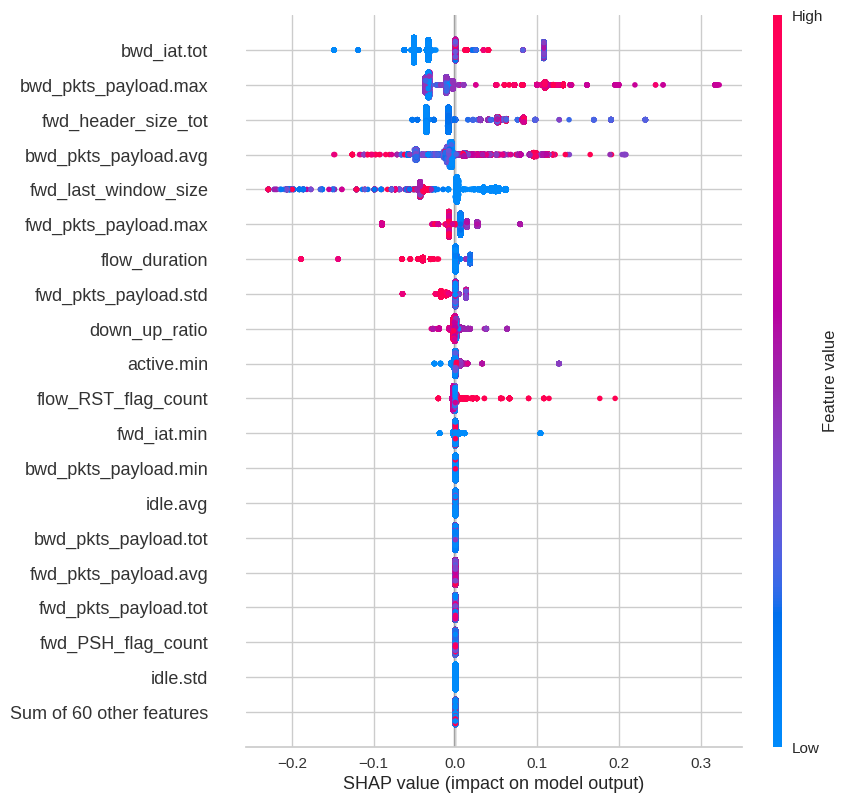

In [71]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce XML shap

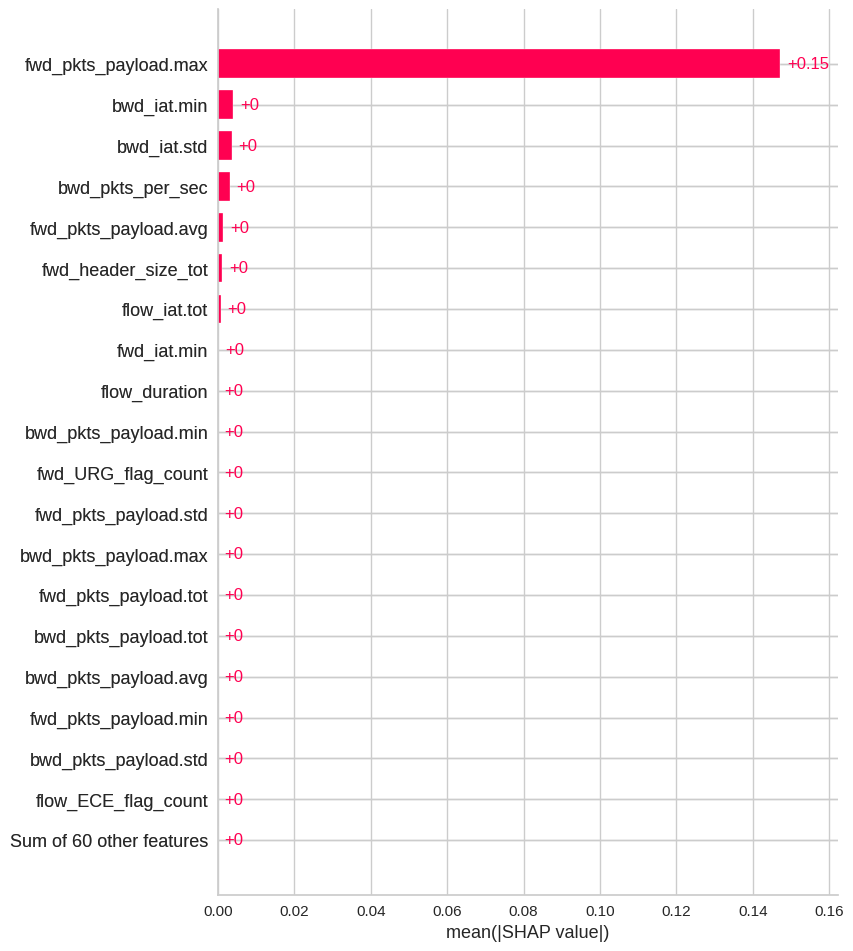

In [72]:
exp = Explanation(sv.values[:,:,2], 
                  sv.base_values[:,2], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

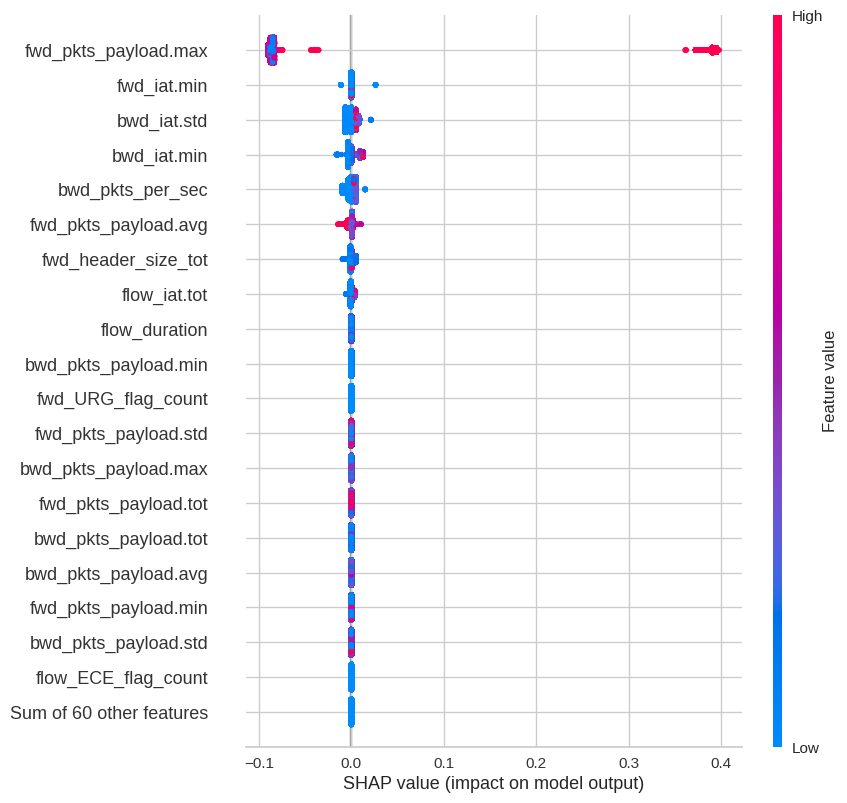

In [73]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

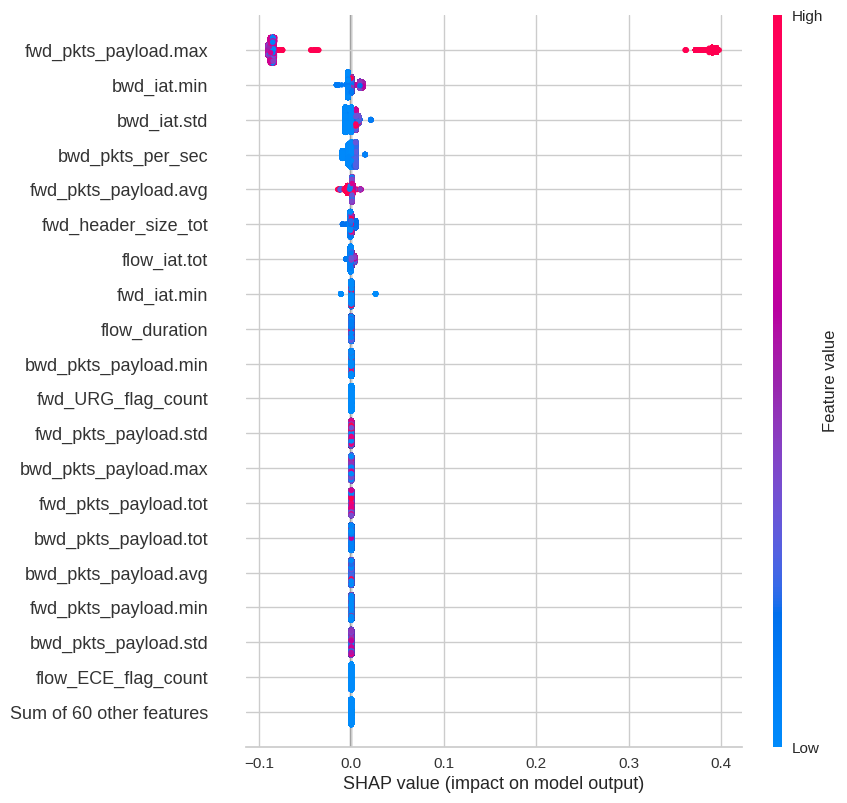

In [74]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Probing shap

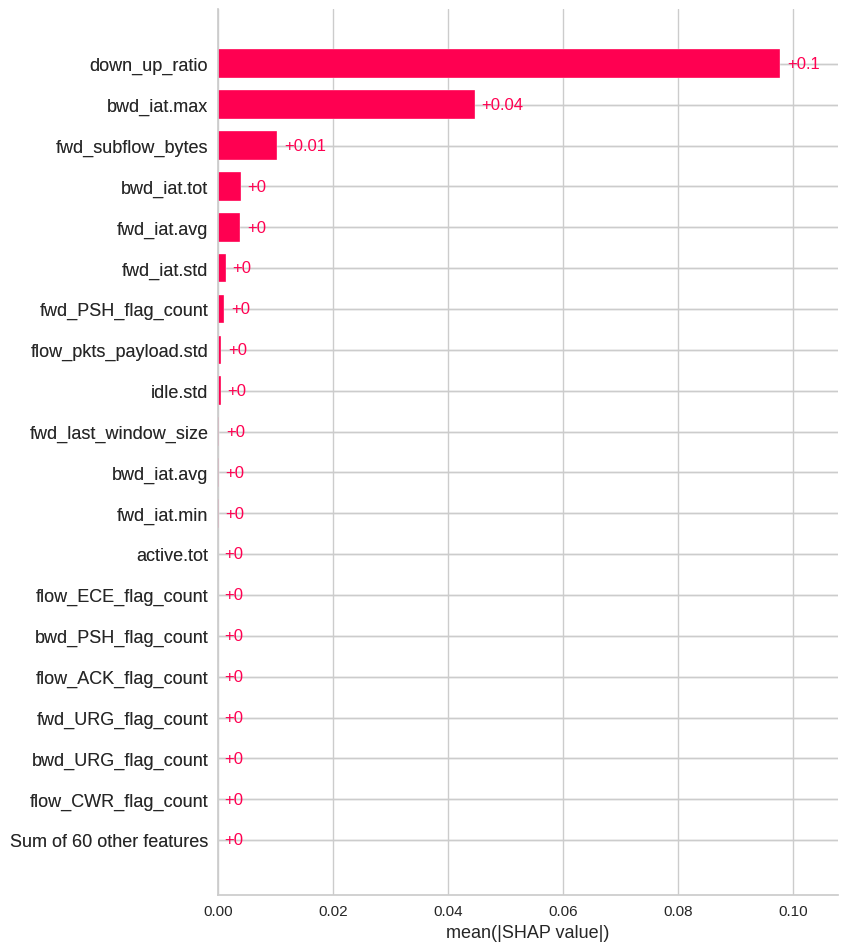

In [75]:
exp = Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

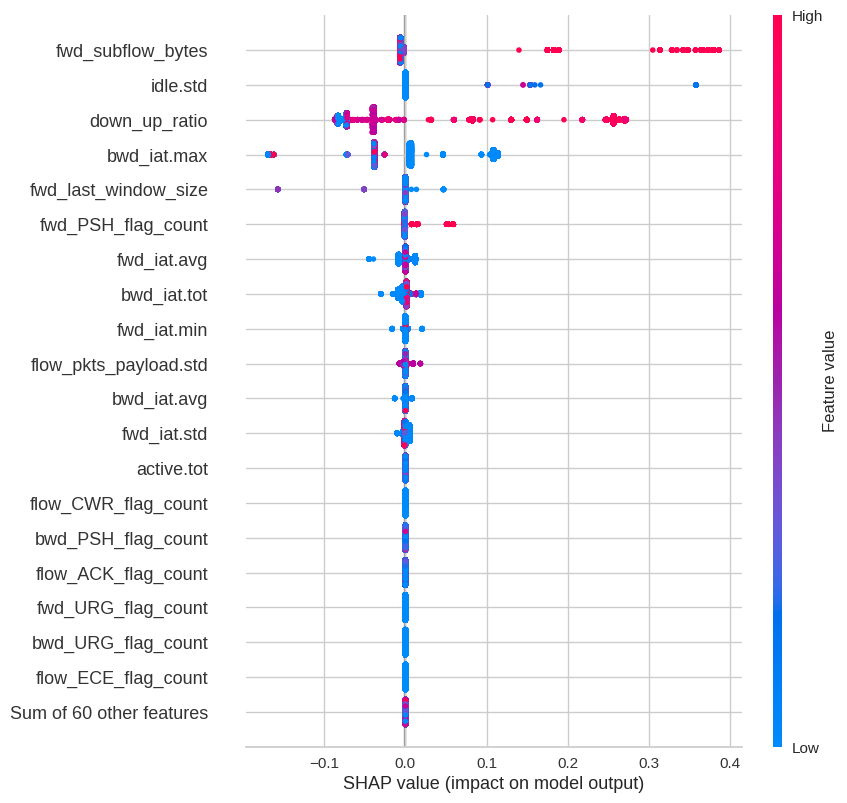

In [76]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

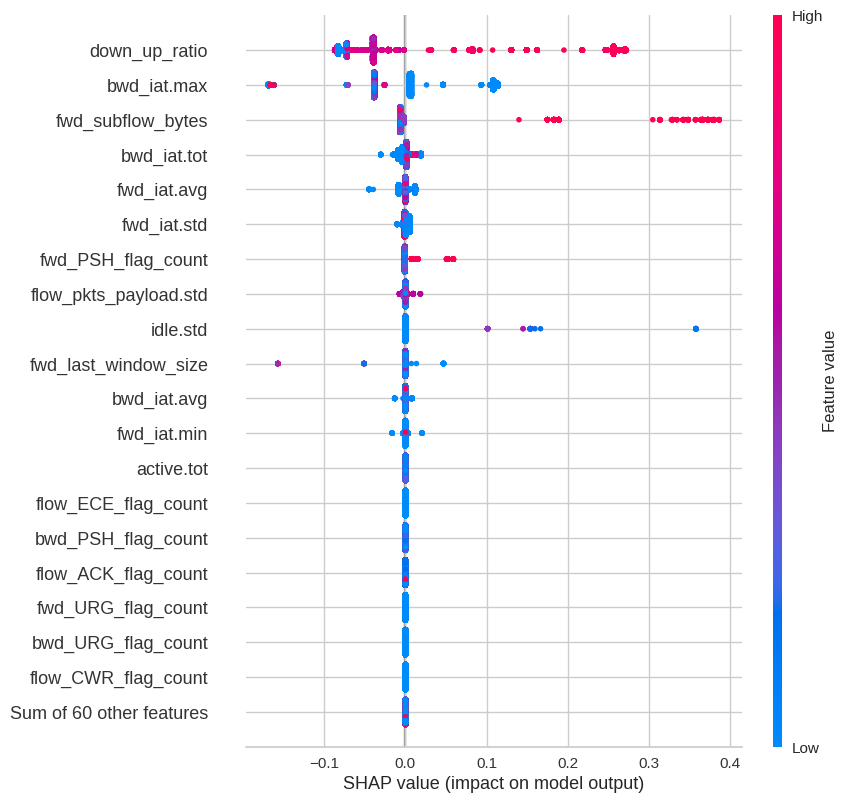

In [77]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Miner shap

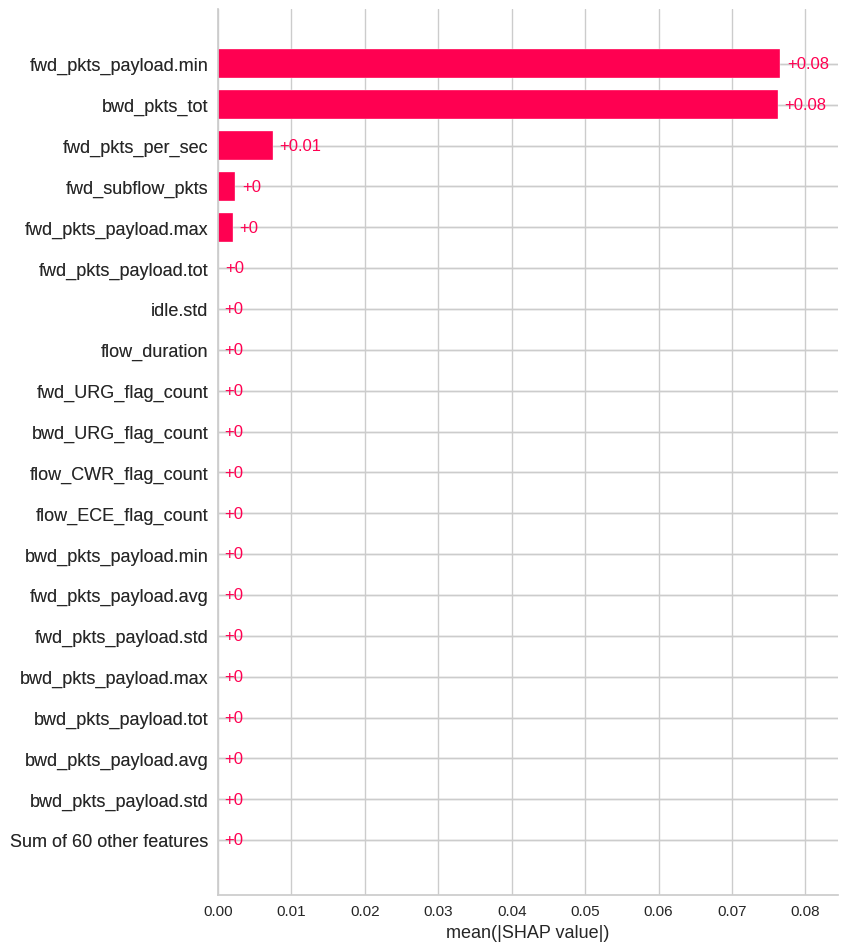

In [78]:
exp = Explanation(sv.values[:,:,4], 
                  sv.base_values[:,4], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

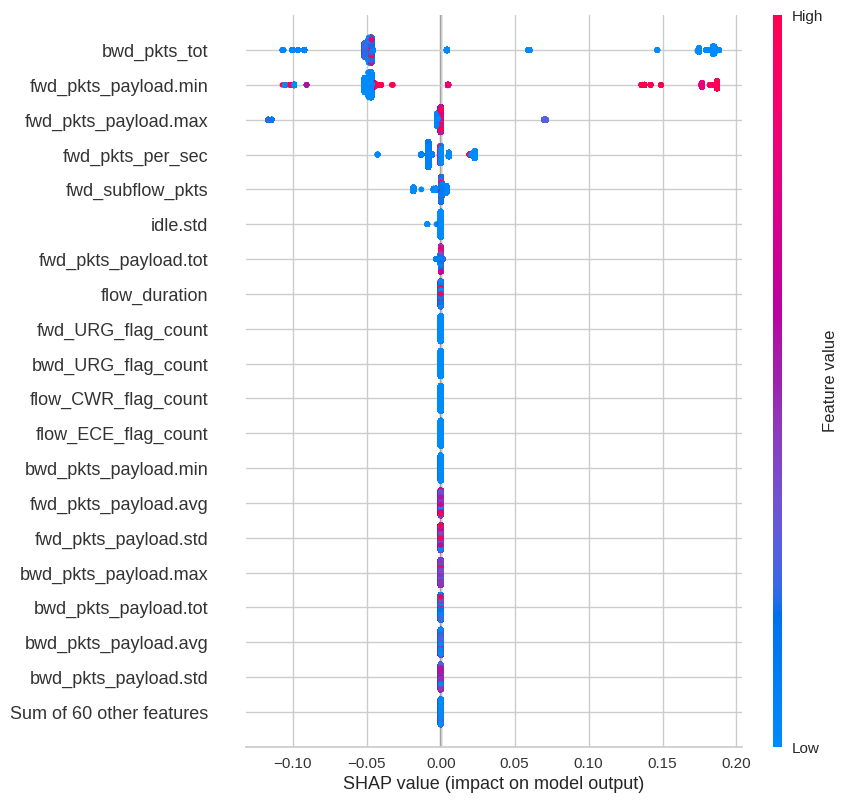

In [79]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

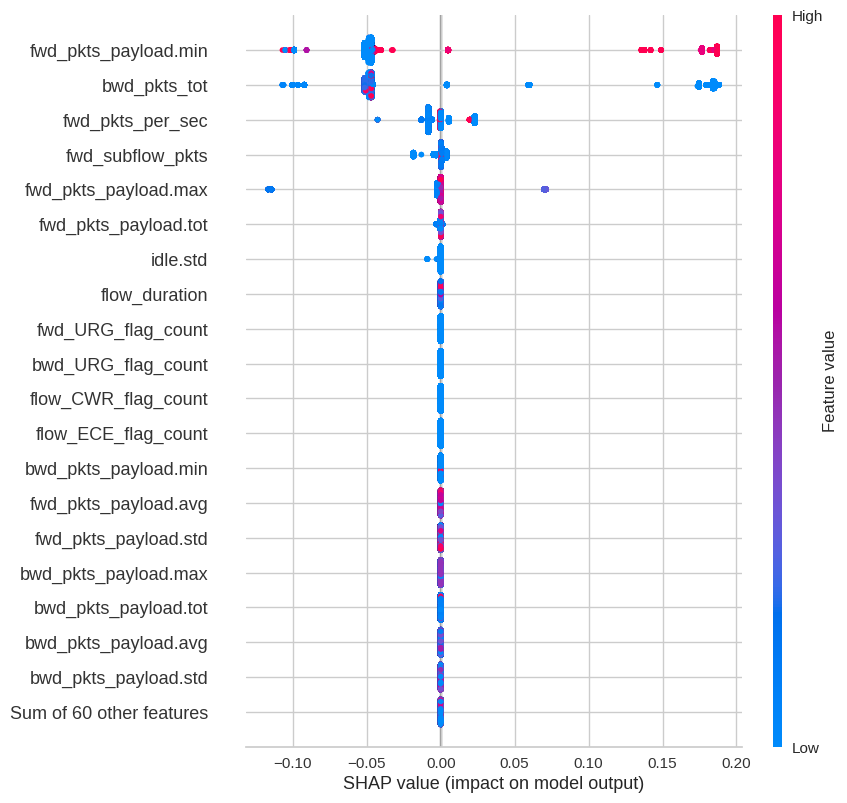

In [80]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Zero day test

In [81]:
classes = sorted(pd.unique(ds['traffic_category']).tolist())

In [82]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'macro')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.964477,0.768528
1,PRECISION,0.966653,0.662273
2,RECALL,0.964481,0.768441
3,F1 SCORE,0.963734,0.703364


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


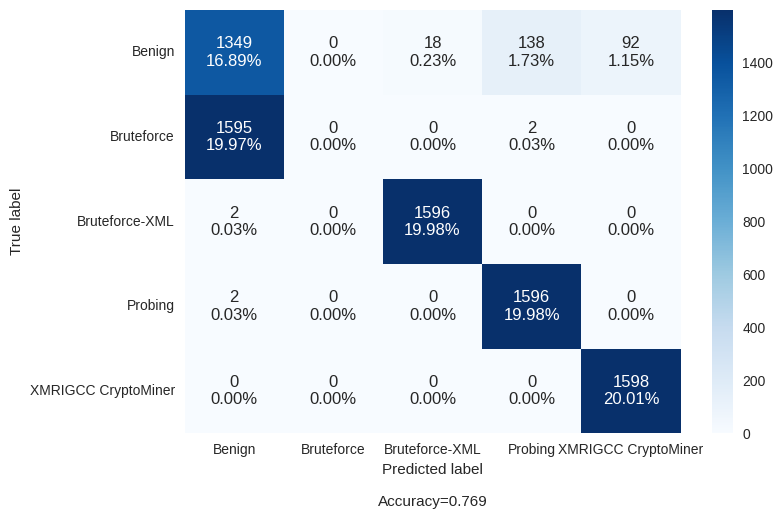

In [83]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [84]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bruteforce-XML']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'macro')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.960566,0.766900
1,PRECISION,0.962572,0.642507
2,RECALL,0.960569,0.766938
3,F1 SCORE,0.959679,0.694363


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


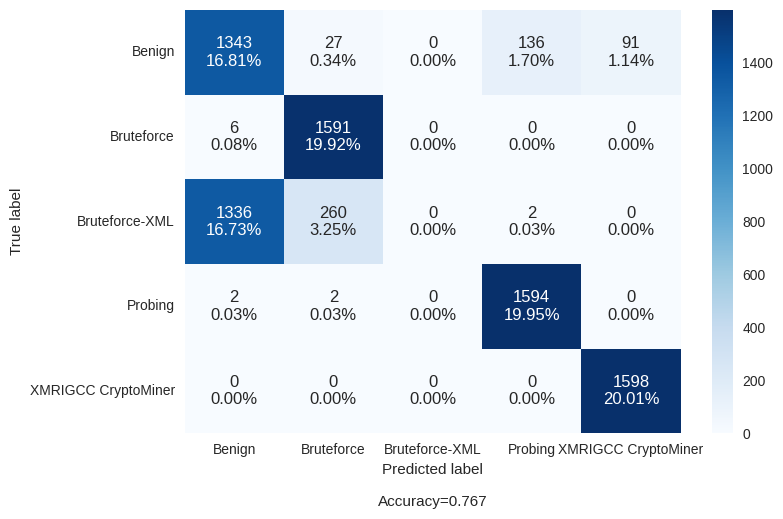

In [85]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [86]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Probing']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'macro')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.981261,0.782549
1,PRECISION,0.981709,0.679843
2,RECALL,0.981263,0.782593
3,F1 SCORE,0.981135,0.717101


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


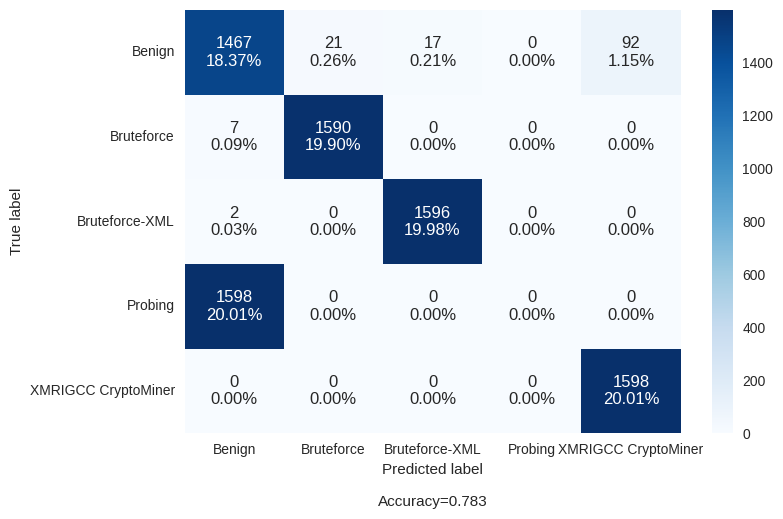

In [87]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [88]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'XMRIGCC CryptoMiner']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
bst.fit(X_train_attack, y_train_attack)
y_predicted_train = bst.predict(X_train_attack)
y_predicted_test = bst.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'macro')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.971990,0.776164
1,PRECISION,0.973442,0.673058
2,RECALL,0.971992,0.776206
3,F1 SCORE,0.971736,0.711223


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


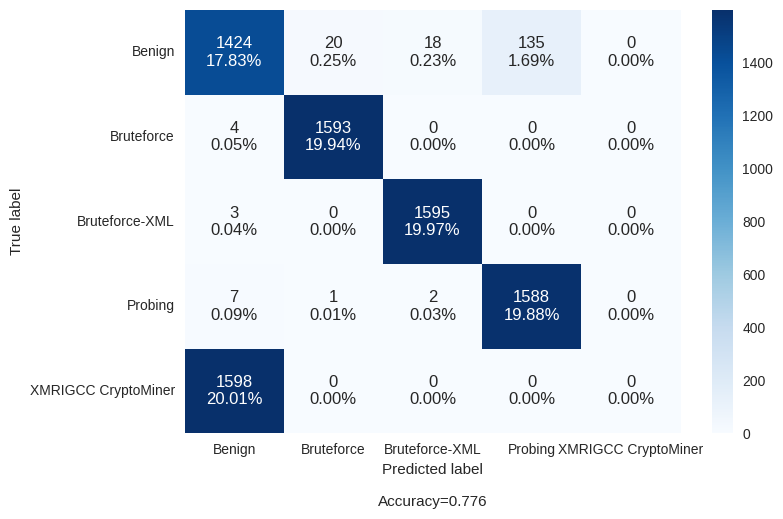

In [89]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')